# CIFAR-10

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

In [2]:
cifar10 = datasets.CIFAR10("data/", train=True, download=True)
cifar10_val = datasets.CIFAR10("data/", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [4]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

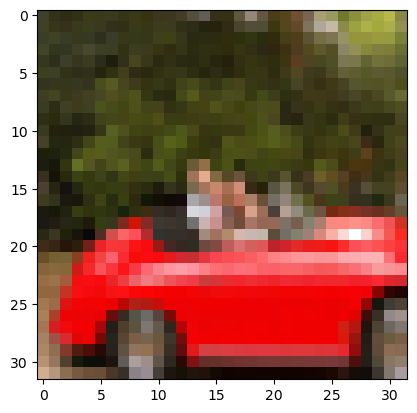

In [5]:
plt.imshow(img)
plt.show()

## Dataset Transforms

In [10]:
names = list(filter(lambda x: x[0].isupper(), list(dir(transforms))))
for i, name in enumerate(names):
    if i == len(names) - 1:
        print(name)
    else:
        print(name, end=", ")

AugMix, AutoAugment, AutoAugmentPolicy, CenterCrop, ColorJitter, Compose, ConvertImageDtype, ElasticTransform, FiveCrop, GaussianBlur, Grayscale, InterpolationMode, Lambda, LinearTransformation, Normalize, PILToTensor, Pad, RandAugment, RandomAdjustSharpness, RandomAffine, RandomApply, RandomAutocontrast, RandomChoice, RandomCrop, RandomEqualize, RandomErasing, RandomGrayscale, RandomHorizontalFlip, RandomInvert, RandomOrder, RandomPerspective, RandomPosterize, RandomResizedCrop, RandomRotation, RandomSolarize, RandomVerticalFlip, Resize, TenCrop, ToPILImage, ToTensor, TrivialAugmentWide


In [12]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [13]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

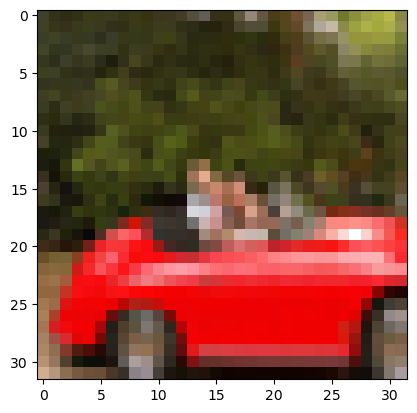

In [15]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [20]:
tensor_cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transforms.ToTensor())

## Normalizing Data

In [24]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [35]:
mean = imgs.view(3, -1).mean(dim=1)

In [36]:
std = imgs.view(3, -1).std(dim=1)

In [37]:
transforms.Normalize(mean, std)

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [42]:
transformed_cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


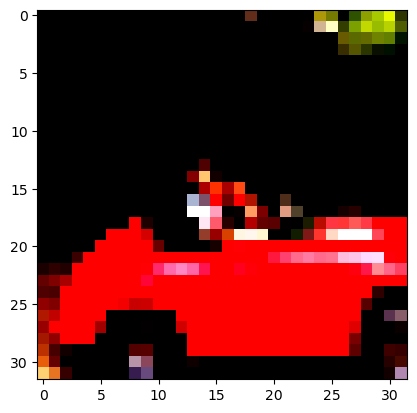

In [43]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Building Dataset

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [7]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [8]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

## Neural Network

In [66]:
in_features = 3 * 32 * 32
hidden_features = 512
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, out_features),
)

## Softmax

In [69]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [72]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x), softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [74]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [75]:
in_features = 3 * 32 * 32
hidden_features = 512
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, out_features),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


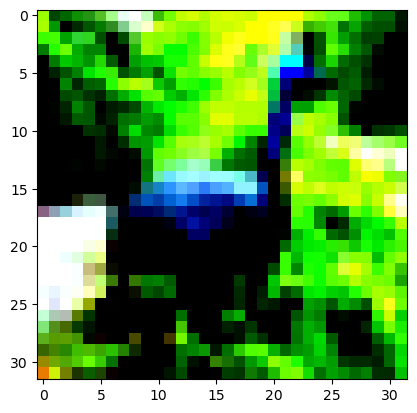

In [76]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [80]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [81]:
out = model(img_batch)
out

tensor([[0.4526, 0.5474]], grad_fn=<SoftmaxBackward0>)

In [82]:
_, index = torch.max(out, dim=1)
index

tensor([1])

## Loss Function

In [83]:
in_features = 3 * 32 * 32
hidden_features = 512
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, out_features),
    nn.LogSoftmax(dim=1)
)

In [88]:
img, _ = cifar2[0]
img_batch = img.view(-1).unsqueeze(0)

out = model(img_batch)
out, torch.exp(out)

(tensor([[-0.6986, -0.6877]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[0.4973, 0.5027]], grad_fn=<ExpBackward0>))

In [87]:
loss = nn.NLLLoss()

In [90]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.6877, grad_fn=<NllLossBackward0>)

## Model Training

In [9]:
in_features = 3 * 32 * 32
hidden_features = 512
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, out_features),
    nn.LogSoftmax(dim=1)
)

In [10]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
loss_fn = nn.NLLLoss()

In [12]:
n_epochs = 5

for epoch in range(n_epochs):
    for img, label in tqdm(cifar2):
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

100%|██████████| 10000/10000 [00:35<00:00, 282.52it/s]


Epoch: 0, Loss: 7.9113


100%|██████████| 10000/10000 [00:38<00:00, 261.87it/s]


Epoch: 1, Loss: 4.9670


100%|██████████| 10000/10000 [00:34<00:00, 292.47it/s]


Epoch: 2, Loss: 5.4440


100%|██████████| 10000/10000 [00:35<00:00, 285.67it/s]


Epoch: 3, Loss: 7.3814


100%|██████████| 10000/10000 [00:34<00:00, 291.52it/s]

Epoch: 4, Loss: 8.9948


In [14]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [15]:
in_features = 3 * 32 * 32
hidden_features = 512
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, out_features),
    nn.LogSoftmax(dim=1)
)

In [16]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
loss_fn = nn.NLLLoss()

In [21]:
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

Epoch: 0, Loss: 0.4505
Epoch: 1, Loss: 0.4914
Epoch: 2, Loss: 0.3790
Epoch: 3, Loss: 0.3210
Epoch: 4, Loss: 0.4104
Epoch: 5, Loss: 0.2110
Epoch: 6, Loss: 0.3906
Epoch: 7, Loss: 0.1097
Epoch: 8, Loss: 0.1377
Epoch: 9, Loss: 0.1424
Epoch: 10, Loss: 0.2565
Epoch: 11, Loss: 0.2014
Epoch: 12, Loss: 0.2368
Epoch: 13, Loss: 0.4294
Epoch: 14, Loss: 0.2803
Epoch: 15, Loss: 0.0991
Epoch: 16, Loss: 0.1636
Epoch: 17, Loss: 0.0938
Epoch: 18, Loss: 0.1384
Epoch: 19, Loss: 0.1045
Epoch: 20, Loss: 0.1618
Epoch: 21, Loss: 0.1086
Epoch: 22, Loss: 0.1025
Epoch: 23, Loss: 0.1091
Epoch: 24, Loss: 0.1132
Epoch: 25, Loss: 0.3186
Epoch: 26, Loss: 0.1638
Epoch: 27, Loss: 0.0859
Epoch: 28, Loss: 0.2062
Epoch: 29, Loss: 0.1206
Epoch: 30, Loss: 0.2026
Epoch: 31, Loss: 0.0577
Epoch: 32, Loss: 0.1070
Epoch: 33, Loss: 0.1129
Epoch: 34, Loss: 0.0303
Epoch: 35, Loss: 0.0898
Epoch: 36, Loss: 0.0317
Epoch: 37, Loss: 0.0328
Epoch: 38, Loss: 0.0475
Epoch: 39, Loss: 0.0201
Epoch: 40, Loss: 0.1041
Epoch: 41, Loss: 0.0328
Ep

In [24]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 81.20%


## Improved Model

In [38]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [29]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [30]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [40]:
in_features = 3 * 32 * 32
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, out_features),
)

In [41]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
loss_fn = nn.CrossEntropyLoss()

100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


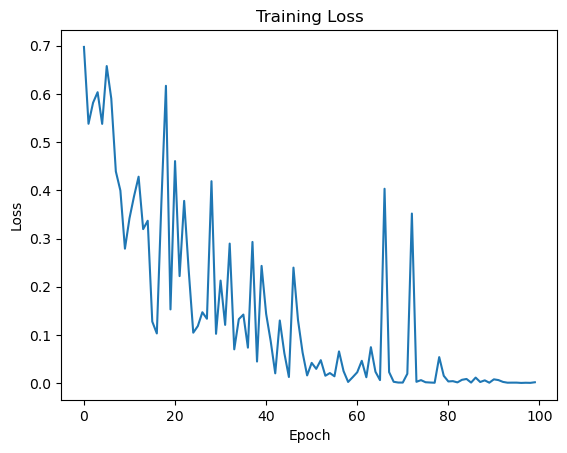

In [43]:
n_epochs = 100
epochs = list(range(n_epochs))
losses = []

for epoch in tqdm(epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [44]:
def evaluate(data_loader, model):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    
    accuracy = 100 * correct / total
    return accuracy

In [45]:
train_accuracy = evaluate(train_loader, model)
val_accuracy = evaluate(val_loader, model)

print(f"Training accuracy: {train_accuracy:.2f}%, Validation accuracy: {val_accuracy:.2f}%")

Training accuracy: 100.00%, Validation accuracy: 81.10%


In [46]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]

sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [48]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

## Exercises

In [2]:
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

### Random Cropping

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [19]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [33]:
crop = transforms.RandomCrop(size=(24, 24))

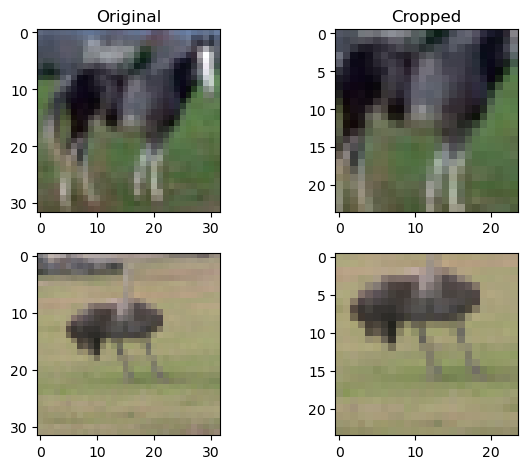

In [44]:
img37, _ = cifar10[37]
img42, _ = cifar10[42]

img37_t = crop(img37)
img42_t = crop(img42)

fig, axs = plt.subplots(2, 2)

axs[0, 0].imshow(img37.permute(1, 2, 0))
axs[0, 1].imshow(img37_t.permute(1, 2, 0))
axs[1, 0].imshow(img42.permute(1, 2, 0))
axs[1, 1].imshow(img42_t.permute(1, 2, 0))

axs[0, 0].set_title("Original")
axs[0, 1].set_title("Cropped")

plt.tight_layout()
plt.savefig("data/cropped-samples.png")
plt.show()

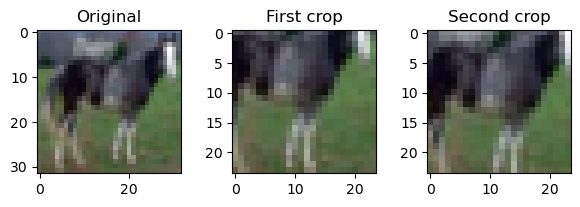

In [43]:
img, _ = cifar10[37]

img_t1 = crop(img)
img_t2 = crop(img)

fig, axs = plt.subplots(1, 3, figsize=(6, 2))

axs[0].imshow(img.permute(1, 2, 0))
axs[1].imshow(img_t1.permute(1, 2, 0))
axs[2].imshow(img_t2.permute(1, 2, 0))

axs[0].set_title("Original")
axs[1].set_title("First crop")
axs[2].set_title("Second crop")

plt.tight_layout()
plt.savefig("data/subsequent-crops.png")
plt.show()

### Training on Cropped Images

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
    transforms.RandomCrop(size=(24, 24)),
])

In [3]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [4]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [5]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [6]:
in_features = 3 * 24 * 24
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, out_features),
)

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
def train(n_epochs, dataloader, model, loss_fn, optimizer):
    epochs = list(range(n_epochs))
    losses = []
    
    for epoch in tqdm(epochs):
        for imgs, labels in dataloader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
    
    plt.plot(epochs, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

In [10]:
def evaluate(dataloader, model):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    
    accuracy = 100 * correct / total
    return accuracy

100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


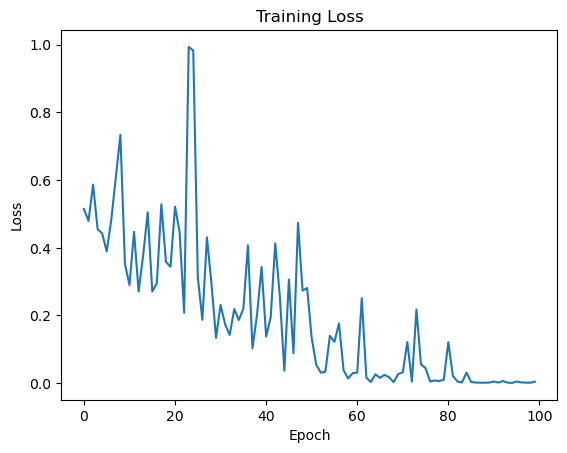

In [11]:
train(
    n_epochs=100,
    dataloader=train_loader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer
)

In [12]:
train_accuracy = evaluate(train_loader, model)
val_accuracy = evaluate(val_loader, model)

print(f"Training accuracy: {train_accuracy:.2f}%, Validation accuracy: {val_accuracy:.2f}%")

Training accuracy: 100.00%, Validation accuracy: 77.15%


### Training with MSE Loss

In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
])

In [32]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [41]:
label_map = {
    0: torch.tensor([1, 0], dtype=torch.float32),
    2: torch.tensor([0, 1], dtype=torch.float32)
}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [42]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [43]:
in_features = 3 * 32 * 32
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, out_features),
)

In [44]:
loss_fn = nn.MSELoss()

In [45]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [46]:
def train(n_epochs, dataloader, model, loss_fn, optimizer):
    epochs = list(range(n_epochs))
    losses = []
    
    for epoch in tqdm(epochs):
        for imgs, labels in dataloader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
    
    plt.plot(epochs, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

In [50]:
def evaluate(dataloader, model):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, pred = torch.max(outputs, dim=1)
            _, gt = torch.max(labels, dim=1)
            total += labels.shape[0]
            correct += int((pred == gt).sum())
    
    accuracy = 100 * correct / total
    return accuracy

100%|██████████| 100/100 [03:49<00:00,  2.30s/it]


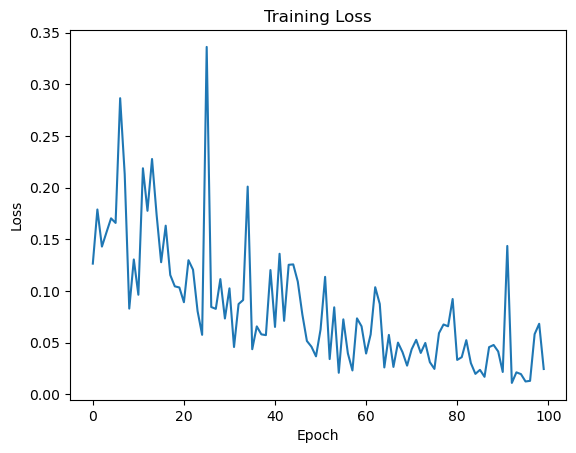

In [48]:
train(
    n_epochs=100,
    dataloader=train_loader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer
)

In [51]:
train_accuracy = evaluate(train_loader, model)
val_accuracy = evaluate(val_loader, model)

print(f"Training accuracy: {train_accuracy:.2f}%, Validation accuracy: {val_accuracy:.2f}%")

Training accuracy: 98.83%, Validation accuracy: 79.55%


### Simpler Neural Network

In [52]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [54]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [55]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [56]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [82]:
in_features = 3 * 32 * 32
out_features = 2

model = nn.Sequential(
    nn.Linear(in_features, 2),
    nn.ReLU(),
    nn.Linear(2, out_features),
)

In [83]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [84]:
loss_fn = nn.CrossEntropyLoss()

In [85]:
def train(n_epochs, data_loader, model, loss_fn, optimizer):
    epochs = list(range(n_epochs))
    losses = []

    for epoch in tqdm(epochs):
        for imgs, labels in data_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        losses.append(loss.item())
    
    plt.plot(epochs, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

In [86]:
def evaluate(data_loader, model):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    
    accuracy = 100 * correct / total
    return accuracy

100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


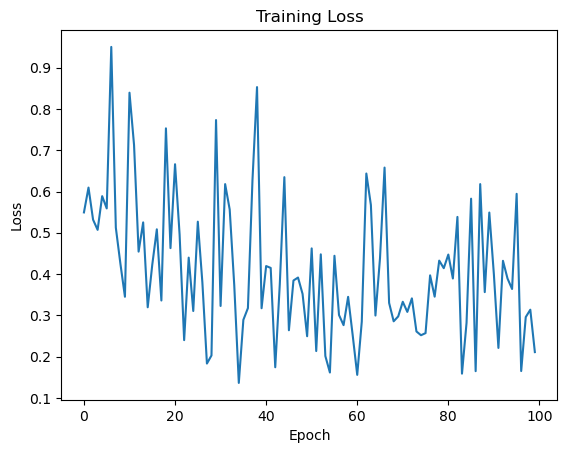

In [87]:
train(
    n_epochs=100,
    data_loader=train_loader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer
)

In [88]:
train_accuracy = evaluate(train_loader, model)
val_accuracy = evaluate(val_loader, model)

print(f"Training accuracy: {train_accuracy:.2f}%, Validation accuracy: {val_accuracy:.2f}%")

Training accuracy: 86.88%, Validation accuracy: 79.55%
